<a href="https://colab.research.google.com/github/linyuehzzz/5523_project/blob/main/sgd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Stochastic Gradient Descent for Logistic Regression**
This code implements and tests the SGD algorithm for logistic regression
in different scenarios.  
Yifei Zhang (zhang.5387 at osu edu), Yue Lin (lin.3326 at osu.edu)  
Created: 11/12/2020

#### **Set up libraries**

In [28]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

#### **Project**

##### Projection function for hypercube

In [2]:
def cube_prj(sample):
  '''
  input: a sample with d dimension (1-D array or list)
  onput: the euclidean projection of sample
  '''
  return [np.sign(i) * min(np.abs(i), 1) for i in sample]

##### Projection function for unit ball

In [3]:
def ball_prj(sample):
    '''
    input: a sample with d dimension (1-D array or list)
    onput: the euclidean projection of sample
    '''
    ratio = 1 / np.linalg.norm(sample)
    return [i * ratio for i in sample]

##### Project data

In [4]:
def prj_data(x, y, prj_code):
    '''
    This function is for conduct projection on data array
    x: n*d array (n is sample#, d is dimension)
    y: 1-d array with label of -1 or +1
    prj_code: type of projection, 0 for cube, 1 for ball
    return:
        prj_x: projected x 
        y: same as input
    '''
    if prj_code == 0:
        prj_x = np.apply_along_axis(cube_prj, 1, x)
    elif prj_code == 1:
        prj_x = np.apply_along_axis(ball_prj, 1, x)
    else:
        print("Please input correct code for projection type: 0 for cube, 1 for ball")
      
    b = np.ones((prj_x.shape[0], 1))
    prj_x = np.append(prj_x, b, axis=1)
    return prj_x, y

##### Project gradient

In [5]:
def prj_grad(g, prj_code):
    '''
    This function is for conduct projection on gradients
    g: 1-d array (d is dimension)
    prj_code: type of projection, 0 for cube, 1 for ball
    return:
        prj_g: projected gradient
    '''
    if prj_code == 0:
        prj_g = cube_prj(g)
    elif prj_code == 1:
        prj_g = ball_prj(g)
    else:
        print("Please input correct code for projection type: 0 for cube, 1 for ball")
    return prj_g

#### **Prepare data**

In [6]:
def gen_data(sig, n):
    '''
    The function is to generate data for training and testing
    The feature array is 4 dimension array. 
     + Each feature follows the Normal distribution(mu,sig)
     + with probability 1/2, the y =1 , 
         generate the correspoinding feature vector from N(mu,sig),mu is [1/4,1/4,1/4,1/4],sig is set as you need.
    sig: the sigma of  gussian vector
    n: the sample number
    
    Return:
     x: n*d_dimension array
     y: 1-d dimension array with -1 and +1
    '''
    d_dimension = 4
    y = np.random.choice([-1, 1], p = [0.5, 0.5], size = n)
    x = np.array([])
    for i in range(n):
        if y[i] == -1:
            mu = -(1 / 4)
            negvec = np.random.normal(mu, sig, d_dimension)
            x = np.concatenate([x, negvec], axis=0)
        else:
            mu = (1/4)
            posvec = np.random.normal(mu, sig, d_dimension)
            x = np.concatenate([x,posvec], axis=0)
    x = np.reshape(x, (n, d_dimension))
    return x, y

#### **Train**
https://machinelearningmastery.com/implement-logistic-regression-stochastic-gradient-descent-scratch-python/

##### Predict using logistic regression

In [22]:
# Make a prediction with coefficients
def pred(X, w):
    yhat = 0.
    for i in range(X.shape[0]):
        yhat += w[i] * X[i]
    yhat = 1.0 / (1.0 + np.exp(-yhat))
    if yhat < 0.5:
        yhat = -1
    else:
        yhat = 1 
    return yhat

##### Estimate logistic loss

In [23]:
def log_loss(X, y, w):
    return np.log(1 + np.exp(-y * np.dot(w.T, X)))

##### Estimate classification error

In [24]:
def err(yhat, y):
    if yhat == y:
        return 0
    else:
        return 1

##### Estimate weight vector using SGD

In [10]:
def train_sgd(train_x, train_y, test_x, test_y, l_rate, n_epoch, bs, prj_code):
  w = np.random.uniform(-1, 1, (train_x.shape[1]))
  risk_all = np.zeros(n_epoch)
  cls_err_all = np.zeros(n_epoch)

  for epoch in range(n_epoch):
    risk = cls_err = grad = 0.
    for idx in range(epoch * bs, (epoch + 1) * bs):
      # Read data
      X = train_x[idx]
      y = train_y[idx]
      # Calculate gradient
      g = (-y * X * np.exp(-y * np.dot(w.T, X)) / (1 + np.exp(-y * np.dot(w.T, X))))
      grad += g

    # Project gradient
    grad = prj_grad(grad / bs, prj_code)
    # Backward propagation
    w = np.add(w, np.multiply(-l_rate, grad))
    
    # Evaluate
    for idx in range(test_x.shape[0]):
      # Read data
      X = test_x[idx]
      y = test_y[idx]
      # Predict
      yhat = pred(X, w)
      # Evaluate
      risk += log_loss(X, y, w) / test_x.shape[0]
      cls_err += err(yhat, y) / test_x.shape[0]
    
    risk_all = np.append(risk_all, risk)
    cls_err_all = np.append(cls_err_all, cls_err)
    # print('>epoch=%d, lrate=%.3f, risk=%.3f, classification error=%.3f' % (epoch, l_rate, risk, cls_err))
  
  # Report risk
  risk_ave = np.average(risk_all)
  risk_min = np.amin(risk_all)
  risk_var = np.var(risk_all)
  exp_excess_risk = risk_ave - risk_min
  # Report classification error
  cls_err_ave = np.average(cls_err_all)
  cls_err_var = np.var(cls_err_all)
  return [w, risk_ave, risk_min, risk_var, exp_excess_risk, cls_err_ave, cls_err_var]

#### **Wrapper**

##### Generate data and train

In [17]:
# Fixed hyperparameters
n_epoch = 30    # training epochs
test_n = 400    # size of test set

# Unfixed hyperparameters
prj_code = 0   # code for two scenario: 0 for cube, 1 for ball
l_rate = 0.04  # learning rate: 0.04 for cube, 0.18 for ball
train_bs = np.array([50, 100, 500, 1000])   # batch size for each training epoch
sigma = 0.1     # variance of Gaussian distribution

np.random.seed(0)

excess_risk = []
cls_error = []
excess_risk_var = []
cls_error_var = []

for bs in train_bs:
  # Generate training data
    train_x, train_y = gen_data(sigma, bs * n_epoch)
    train_px, train_py = prj_data(train_x, train_y, prj_code)

    # Generate test data
    test_x, test_y = gen_data(sigma, test_n)
    test_px, test_py = prj_data(test_x, test_y, prj_code)

    # Train
    output = train_sgd(train_px, train_py, test_px, test_py, l_rate, n_epoch, bs, prj_code)
    #[w, risk_ave, risk_min, risk_var, exp_excess_risk, cls_err_ave, cls_err_var]
    
    print(output)
    print('>scenario=%d, sigma=%.2f, n=%d, log_loss_mean=%.3f, log_loss_std_dev=%.3f, log_loss_min=%.3f, \
        excess_risk=%.3f, cls_error_mean=%.3f, cls_error_std_dev=%.3f' 
        % (prj_code+1, sigma, bs, output[1], output[3], output[2], output[4], output[5], output[6]))

    excess_risk = np.append(excess_risk, output[4], axis=None)
    cls_error = np.append(cls_error, output[5],  axis=None)
    excess_risk_var = np.append(excess_risk_var, output[3], axis=None)
    cls_error_var = np.append(cls_error_var, output[6],  axis=None)

[array([ 0.81537278,  1.02232637,  0.92469896, -0.78591769,  0.52977064]), 0.2784881499866211, 0.0, 0.07781306677034856, 0.2784881499866211, 0.20395833333333352, 0.04419131076388896]
>scenario=1, sigma=0.10, n=50, log_loss_mean=0.278, log_loss_std_dev=0.078, log_loss_min=0.000,         excess_risk=0.278, cls_error_mean=0.204, cls_error_std_dev=0.044
[array([-0.48435138,  0.68363435,  0.24215182, -0.09152958,  0.15859294]), 0.3492377865116855, 0.0, 0.12221683778213396, 0.3492377865116855, 0.2544166666666666, 0.06508861805555555]
>scenario=1, sigma=0.10, n=100, log_loss_mean=0.349, log_loss_std_dev=0.122, log_loss_min=0.000,         excess_risk=0.349, cls_error_mean=0.254, cls_error_std_dev=0.065
[array([-0.46596826,  0.42713659,  0.09867475,  0.01865117,  0.396528  ]), 0.37927173433541267, 0.0, 0.14424049478114467, 0.37927173433541267, 0.2599999999999999, 0.06759999999999998]
>scenario=1, sigma=0.10, n=500, log_loss_mean=0.379, log_loss_std_dev=0.144, log_loss_min=0.000,         excess_

#### To run all experiments

In [ ]:
# Fixed hyperparameters
n_epoch = 30    # training epochs
test_n = 400    # size of test set

# Unfixed hyperparameters
prj_code = 0   # code for two scenario: 0 for cube, 1 for ball
l_rate = 0.04  # learning rate: 0.04 for cube, 0.18 for ball
train_bs = np.array([50, 100, 500, 1000])   # batch size for each training epoch
sigma = 0.1     # variance of Gaussian distribution
np.random.seed(0)

In [137]:
result_list=[]
for prj_code in [0,1]:
    for sigma in [0.1,0.35]:
        for bs in train_bs:
          # Generate training data
            train_x, train_y = gen_data(sigma, bs * n_epoch)
            train_px, train_py = prj_data(train_x, train_y, prj_code)

            # Generate test data
            test_x, test_y = gen_data(sigma, test_n)
            test_px, test_py = prj_data(test_x, test_y, prj_code)

            # Train
            output = train_sgd(train_px, train_py, test_px, test_py, l_rate, n_epoch, bs, prj_code)
            #[w, risk_ave, risk_min, risk_var, exp_excess_risk, cls_err_ave, cls_err_var]

#             print(output)
#             print('>scenario=%d, sigma=%.2f, n=%d, log_loss_mean=%.3f, log_loss_std_dev=%.3f, log_loss_min=%.3f, \
#                 excess_risk=%.3f, cls_error_mean=%.3f, cls_error_std_dev=%.3f' 
#                 % (prj_code+1, sigma, bs, output[1], output[3], output[2], output[4], output[5], output[6]))
            result=[prj_code+1, sigma, bs, 30,output[1], output[3], output[2], output[4], output[5], output[6]]
            result_list.append(result)


In [145]:
column_name=["Scenario","sigma","N","#trails","Loss_Mean","Loss_StdDev","Loss_Min","Loss_ExcessRisk",
             "Error_Mean","Error_StdDev"]

In [146]:
result_df=pd.DataFrame(result_list,columns=column_name)
result_df

,Scenario,sigma,N,#trails,Loss_Mean,Loss_StdDev,Loss_Min,Loss_ExcessRisk,Error_Mean,Error_StdDev
0,1,0.10,50,30,0.377945,0.143347,0.0,0.377945,0.256250,0.065664
1,1,0.10,100,30,0.230124,0.053061,0.0,0.230124,0.052208,0.003997
2,1,0.10,500,30,0.543204,0.295978,0.0,0.543204,0.327042,0.107060
3,1,0.10,1000,30,0.276275,0.076442,0.0,0.276275,0.008250,0.000135
4,1,0.35,50,30,0.256690,0.066085,0.0,0.256690,0.155125,0.025419
5,1,0.35,100,30,0.432885,0.187941,0.0,0.432885,0.326083,0.106390
6,1,0.35,500,30,0.378052,0.143297,0.0,0.378052,0.238958,0.057198
7,1,0.35,1000,30,0.321808,0.103821,0.0,0.321808,0.231375,0.054068
8,2,0.10,50,30,0.288407,0.093159,0.0,0.288407,0.154667,0.046588
9,2,0.10,100,30,0.329476,0.120796,0.0,0.329476,0.192667,0.052793


#### To plot Individual Plot

+ Plot excess risk

In [141]:
resultdf1=resultdf[np.logical_and(result_df["Scenario"]==1,result_df["sigma"]==0.1)]
excess_risk = resultdf1["Loss_ExcessRisk"]
cls_error = resultdf1["Error_Mean"]
excess_risk_var = resultdf1["Loss_StdDev"]
cls_error_var = resultdf1["Error_Mean"]

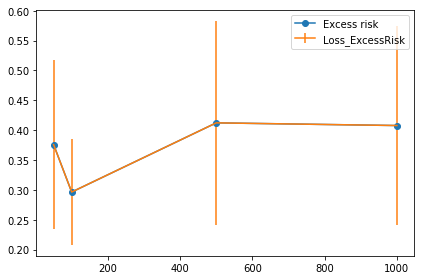

In [142]:
plt.plot(train_bs, excess_risk, '-o', label='Excess risk')
plt.errorbar(train_bs, excess_risk, excess_risk_var)
plt.legend()
plt.tight_layout()
plt.show()

+ Plot classification error

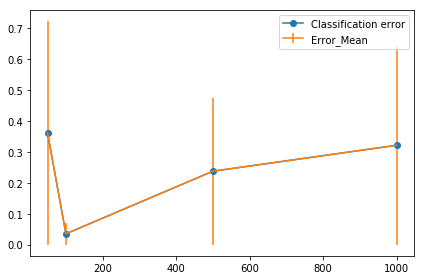

In [143]:
plt.plot(train_bs, cls_error, '-o', label='Classification error')
plt.errorbar(train_bs, cls_error, cls_error_var)
plt.legend()
plt.tight_layout()
plt.show()

#### Plot Grid

In [144]:
def plot_result(estimator):
    '''
    estimator: 
        0 is for ["Loss_ExcessRisk","Loss_StdDev"]
        1 is for ["Error_Mean","Error_Mean"]
    
    '''
    if estimator==0:
        col=["Loss_ExcessRisk","Loss_StdDev"]
    else:
        col=["Error_Mean","Error_Mean"]
        
    fig=plt.figure(figsize=(16,10))
    index=0
    for senario in [1,2]:
        for sigma in [0.1,0.35]:
            index += 1
            plt.subplot(2,2,index)
            df=resultdf[np.logical_and(resultdf["Scenario"]==senario,resultdf["sigma"]==sigma)]
            excess_risk,excess_risk_var = df[col[0]],df[col[1]]

            plt.plot(train_bs, excess_risk, '-o', label=col[0])
            plt.errorbar(train_bs, excess_risk, excess_risk_var)

            plt.xlabel("N",fontsize=12)
            plt.xticks(fontsize=12)
            plt.ylabel("Risk",fontsize=12)
            plt.yticks(fontsize=12)
            plt.title("Scenario "+str(senario)+", Sigma="+str(sigma),fontsize=15) 
    fig.legend(col,loc="upper right",fontsize=13)
    plt.tight_layout()
    plt.show()

##### Plot excess risk

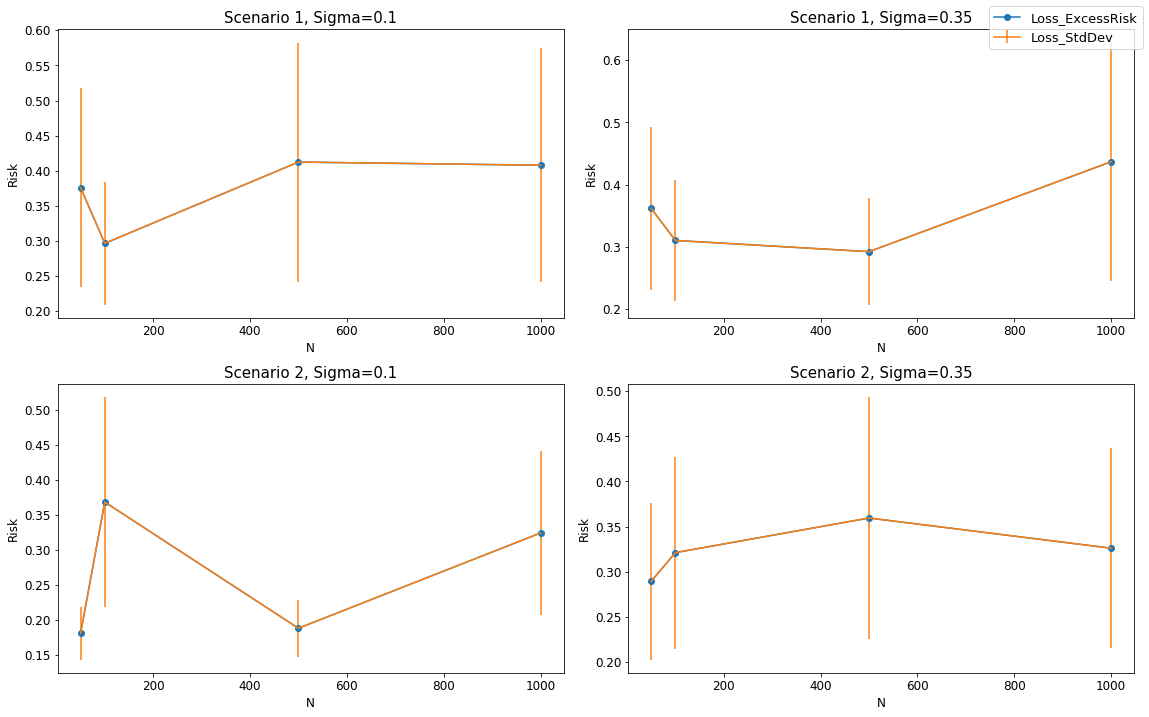

In [134]:
plot_result(0)

##### Plot classification error

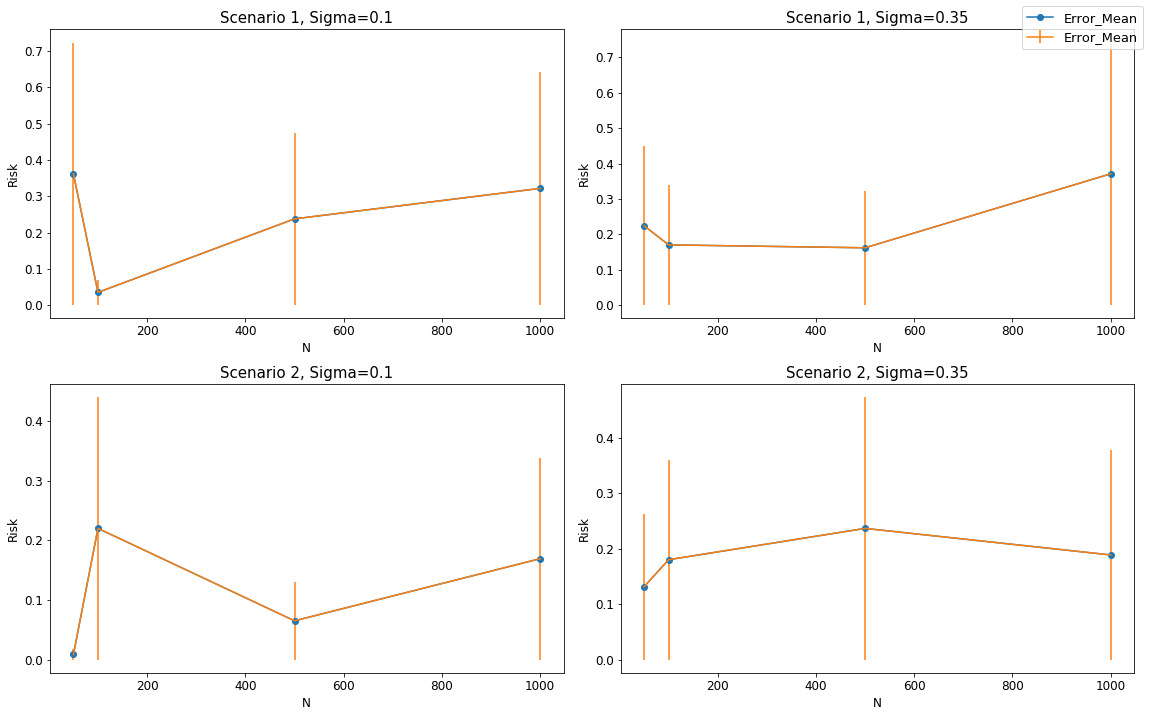

In [135]:
plot_result(1)